In [99]:
import os
import json
import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K


In [100]:
def load_images_and_masks(image_paths, json_paths, image_size=(256, 256), point_size=3):
    images = []
    masks = []

    for img_path, json_path in zip(image_paths, json_paths):
        img = cv2.imread(img_path)
        original_size = img.shape[:2] 
        img = cv2.resize(img, image_size)
        images.append(img)

        mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Błąd odczytu JSON {json_path}: {e}")
            continue  

        if not isinstance(json_data, list):
            print(f"Nieprawidłowy format JSON w {json_path}, oczekiwano listy!")
            continue

        for item in json_data:
            if 'x' in item and 'y' in item and 'label_id' in item:
                x, y, label = int(item['x']), int(item['y']), int(item['label_id'])

                x = int((x / original_size[1]) * image_size[1])
                y = int((y / original_size[0]) * image_size[0])

                if 0 <= x < image_size[1] and 0 <= y < image_size[0]: 
                    color = (1, 0, 0) if label == 1 else (0, 1, 0) if label == 2 else (0, 0, 1)
                    cv2.circle(mask, (x, y), point_size, color, -1)  

        masks.append(mask)

    return np.array(images), np.array(masks, dtype=np.float32)




def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

In [101]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def max_pool(x):
    return layers.MaxPooling2D((2, 2))(x)

def upsample_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x


In [102]:
def unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512]):
    inputs = layers.Input(input_shape)

    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    up6 = upsample_block(conv5, conv4, filterd_vector[3])
    up7 = upsample_block(up6, conv3, filterd_vector[2])
    up8 = upsample_block(up7, conv2, filterd_vector[1])
    up9 = upsample_block(up8, conv1, filterd_vector[0])

    outputs = layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(up9)

    model = models.Model(inputs, outputs)
    return model

In [103]:
train_images_paths, train_json = load_files('SHIDC-B-Ki-67/bare images/Train')
test_images_paths, test_json = load_files('SHIDC-B-Ki-67/bare images/Test')
X_train, Y_train = load_images_and_masks(train_images_paths, train_json)
X_test, Y_test = load_images_and_masks(test_images_paths, test_json)

print(f"Dane treningowe: obrazy {X_train.shape}, maski {Y_train.shape}")
print(f"Dane testowe: obrazy {X_test.shape}, maski {Y_test.shape}")



Dane treningowe: obrazy (1656, 256, 256, 3), maski (1656, 256, 256, 3)
Dane testowe: obrazy (700, 256, 256, 3), maski (700, 256, 256, 3)


In [104]:
pred_mask_dir = "predicted_masks"
if not os.path.exists(pred_mask_dir):
    os.makedirs(pred_mask_dir)

model = unet(output_channels=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=24, validation_data=(X_test, Y_test))
K.clear_session() 

Epoch 1/10
69/69 [==============================] - 27s 380ms/step - loss: 0.3539 - accuracy: 0.7529 - val_loss: 0.0625 - val_accuracy: 0.0507
Epoch 2/10
69/69 [==============================] - 26s 376ms/step - loss: 0.0493 - accuracy: 0.1146 - val_loss: 0.0442 - val_accuracy: 0.0713
Epoch 3/10
69/69 [==============================] - 26s 377ms/step - loss: 0.0396 - accuracy: 0.1004 - val_loss: 0.0382 - val_accuracy: 0.0950
Epoch 4/10
69/69 [==============================] - 26s 377ms/step - loss: 0.0373 - accuracy: 0.0933 - val_loss: 0.0363 - val_accuracy: 0.0991
Epoch 5/10
69/69 [==============================] - 26s 377ms/step - loss: 0.0370 - accuracy: 0.0898 - val_loss: 0.0387 - val_accuracy: 0.0890
Epoch 6/10
69/69 [==============================] - 26s 377ms/step - loss: 0.0348 - accuracy: 0.0940 - val_loss: 0.0340 - val_accuracy: 0.0995
Epoch 7/10
69/69 [==============================] - 26s 377ms/step - loss: 0.0324 - accuracy: 0.0976 - val_loss: 0.0318 - val_accuracy: 0.0969

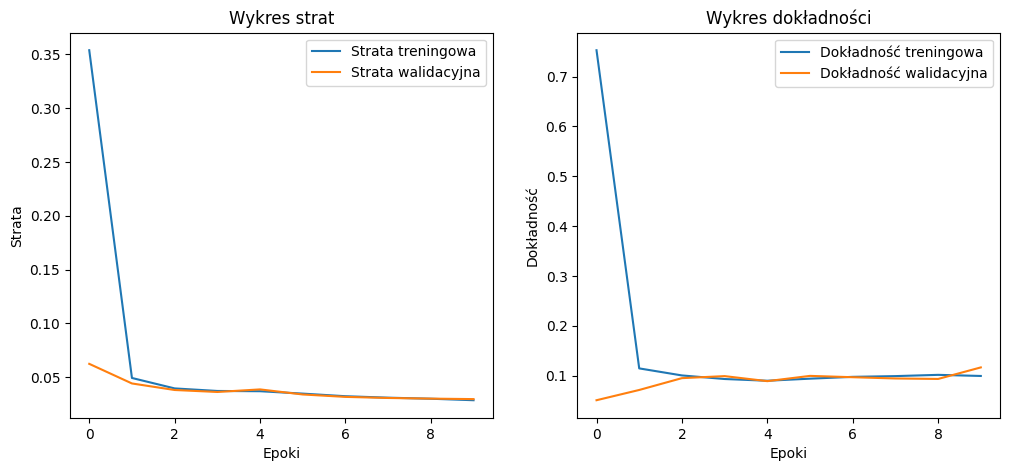

In [108]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Wykres strat')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Wykres dokładności')
plt.legend()

plt.show()

1/1 [==============================] - 0s 16ms/step


Text(0.5, 1.0, 'Prawdziwa maska')

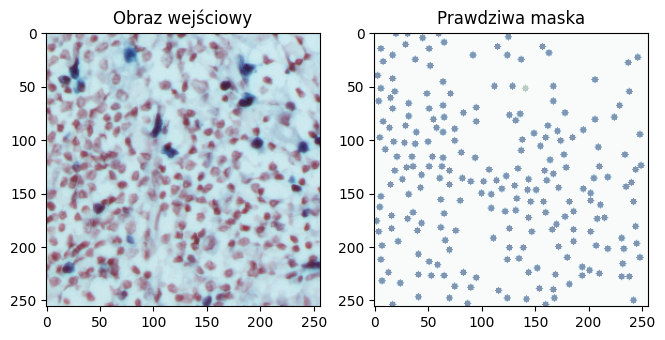

In [113]:
idx = random.randint(0, len(X_test) - 1)
test_img = X_test[idx:idx+1]  
true_mask = Y_test[idx] 
pred_mask = model.predict(test_img)[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5)
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


1/1 [==============================] - 0s 18ms/step


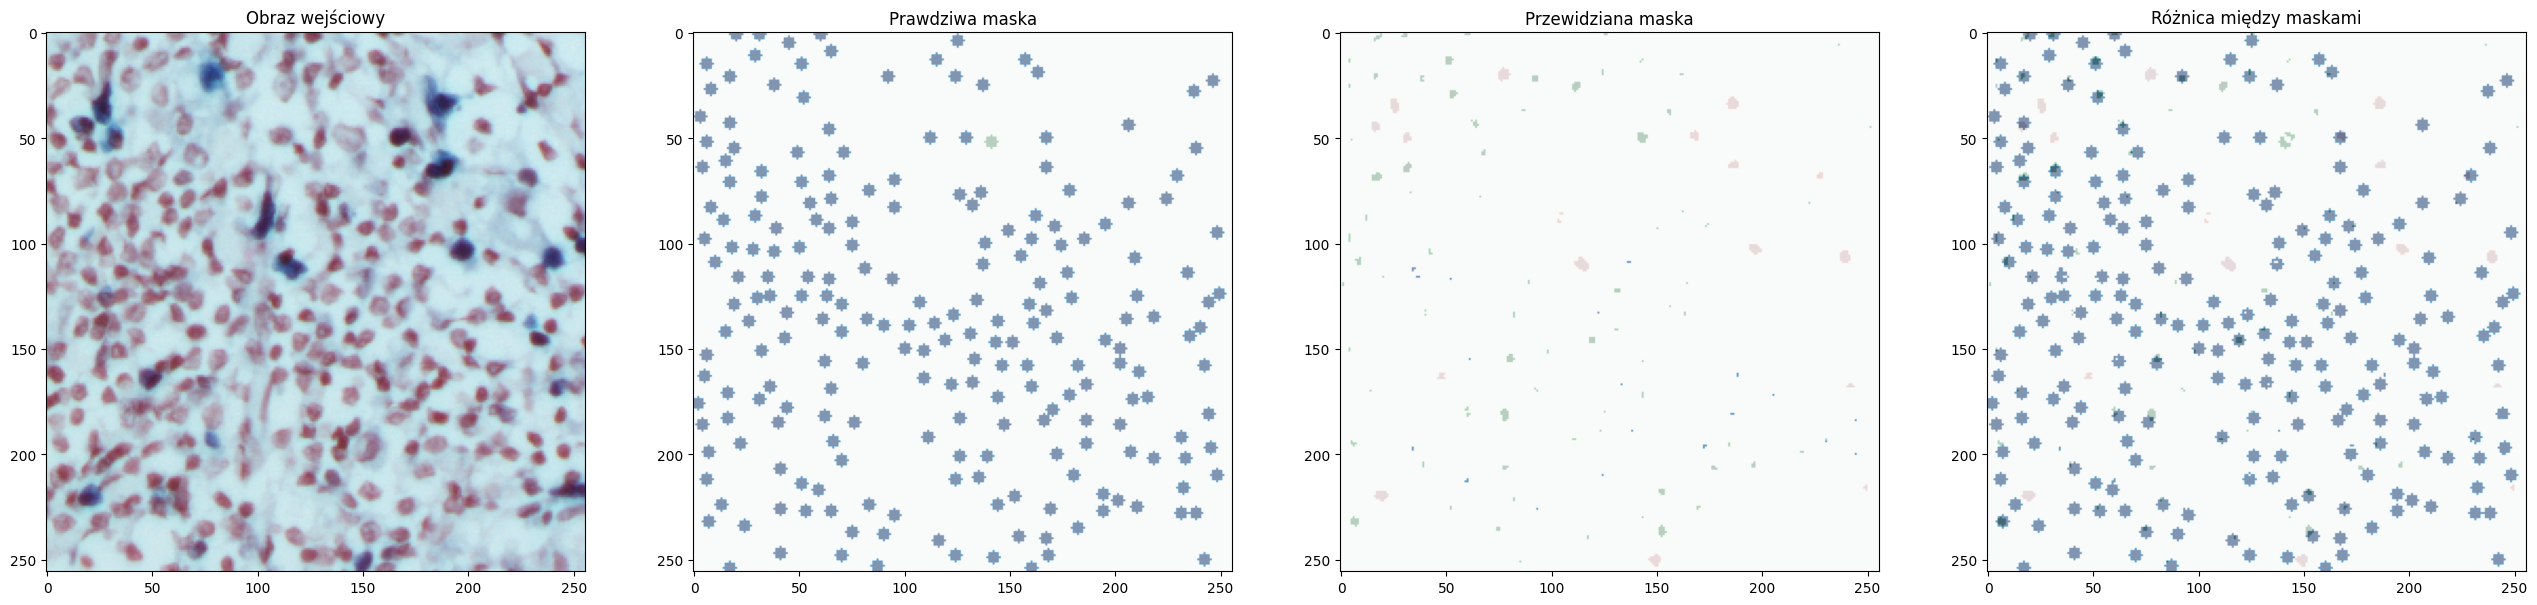

In [114]:
pred_mask = model.predict(test_img)[0]  
pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
mask_diff = np.abs(true_mask - pred_mask_bin)
pred_mask_filename = os.path.join(pred_mask_dir, f"pred_mask_{idx}.png")
cv2.imwrite(pred_mask_filename, (pred_mask_bin * 255).astype(np.uint8))


plt.figure(figsize=(32, 10))

plt.subplot(1, 4, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")

plt.subplot(1, 4, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5)  
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5) 
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


plt.subplot(1, 4, 3)
plt.imshow(pred_mask_bin[:, :, 0], cmap='Reds', alpha=0.5)  
plt.imshow(pred_mask_bin[:, :, 1], cmap='Greens', alpha=0.5) 
plt.imshow(pred_mask_bin[:, :, 2], cmap='Blues', alpha=0.5) 
plt.title("Przewidziana maska")

plt.subplot(1, 4, 4)
plt.imshow(mask_diff[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(mask_diff[:, :, 1], cmap='Greens', alpha=0.5)  
plt.imshow(mask_diff[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Różnica między maskami")

plt.show()
